In [1]:
import networkx as nx
import sys
import os
# dir_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(dir_path)
sys.path.append(r'c:\\Users\\rotim\\OneDrive\\Documents\\Reading\\graph-code\\Skoltech-PhD-Thesis\\_codes\\SIR\\Influential-nodes-identification-in-complex-networks-via-information-entropy')
from algorithms import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle


In [2]:
data_file = 'topo' # 'HepPh'
G = clean_data(data_file)

In [3]:
print(nx.number_of_nodes(G), nx.number_of_edges(G))

34 42


Our Model

In [6]:
geo_loc_data = get_geo_data("Internet2LatLong.csv")
edge_geo_data_combined = assign_location(G, geo_loc_data)
# set edge attributes
set_edge_attr(G, edge_geo_data_combined)
# obtain the node degrees and edges weights to desired lengths
tmp_t = list(range(1, 5))
tmp_t_SN, tmp_t_hub = hubs_SN_NS(G, tmp_t)
# unpack the nodes and edges
tmp_t_SN_1, tmp_t_SN_2, tmp_t_SN_3, tmp_t_SN_4 = tmp_t_SN
tmp_t_hub_1, tmp_t_hub_2, tmp_t_hub_3, tmp_t_hub_4 = tmp_t_hub
# determine variables values
k_max, k_min, k_2_max, k_2_min, sigma, delta = maxi_mini(
    tmp_t_SN_1[1], tmp_t_hub_2[2])
# assign various probability weights
w_d_h, w_d_2_h, w_d_l, w_d_2_l, w_d_t, w_d_2_t = probability_weights(
    tmp_t_SN_1[1], tmp_t_hub_2[2], k_max, k_min, k_2_max, k_2_min, sigma, delta)
# combine into a dictionary
combined_dict, combined_dict_k_2 = covert_to_dict(
    w_d_h, w_d_l, w_d_t), covert_to_dict(w_d_2_h, w_d_2_l, w_d_2_t)
# print(combined_dict, "\n ...... \n", combined_dict_k_2)

# Get ranked result
opti_rank, ranked_nodes = rank_result(combined_dict, combined_dict_k_2)

print(opti_rank, ranked_nodes)



[('27', 0.9985005730418679), ('5', 0.7549436527724699), ('12', 0.7543488781301702), ('28', 0.6538494099071029), ('2', 0.5865976594398602)] [('27', 0.9985005730418679), ('5', 0.7549436527724699), ('12', 0.7543488781301702), ('28', 0.6538494099071029), ('2', 0.5865976594398602), ('8', -0.05045300306636963), ('29', -0.08741203815217125), ('11', -0.09476383267522942), ('33', -0.1785220459582076), ('16', -0.17915011452858887), ('22', -0.21433411540053987), ('14', -0.26103242352740796), ('24', -0.2741646003757832), ('26', -0.3314800344449304), ('7', -0.3477649228285339), ('21', -0.4675182149424362), ('6', -0.5222256043810737), ('23', -0.6131195019583243), ('13', -0.657028903456349), ('32', -0.7094072525888995), ('3', -0.7305873447843266), ('34', -0.7897546865705557), ('15', -0.7933125112241983), ('31', -0.7953706107202866), ('25', -0.797530665360725), ('17', -0.79836359602605), ('19', -0.8073718135156045), ('10', -0.8165377332519865), ('9', -0.8454161947787605), ('4', -0.8715703385708794), (

In [57]:
max_ = len(opti_rank)/nx.number_of_nodes(G)  # 0.16
max_topk = round(max_ * nx.number_of_nodes(G))
print(max_topk)

degreerank = degree(G, max_topk)
print('done!')
degreerank_non = degree_non(G, max_topk)
print('done!')

# vote = voterank(G, max_topk)
# print('done!')
# vote_non = voterank_non(G, max_topk)
# print('done!')

newmethod_rank = EnRenewRank(G, max_topk, 2)
print('done!')

kshell_rank = kshell(G, max_topk)
print('done!')
kshell_rank_non = kshell_non(G, max_topk)
print('done!')


5
done!
done!
done!
done!
done!


In [58]:
print(newmethod_rank)
print(kshell_rank)
print(degreerank) 
print(degreerank_non)


[('5', 0.9097548562597484), ('12', 0.7276923667828582), ('29', 0.6539714380359193), ('14', 0.6058815878364635), ('24', 0.5577917376370076)]
[('2', ' '), ('5', ' '), ('12', ' '), ('6', ' '), ('7', ' ')]
[('2', ' '), ('5', ' '), ('12', ' '), ('6', ' '), ('7', ' ')]
[('2', ' '), ('12', ' '), ('6', ' '), ('8', ' '), ('16', ' ')]


## different lambda

In [59]:
infect_prob = compute_probability(G) * 1.5
avg = 100
max_iter = 200000
topk = round(max_ * nx.number_of_nodes(G))

degreerank_result = []
degreerank_non_result = []
vote_result = []
vote_non_result = []
newmethod_result = []
newmethod_non_result = []
kshell_result = []
kshell_non_result = []
evbrM_result = []
# atio = [a/10 for a in list(range(10, 21, 2))]

for a in tqdm(range(10, 21, 2)):
    atio = a / 10
    cover_prob = infect_prob / atio
    degreerank_result.append(get_sir_result(G, degreerank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    degreerank_non_result.append(get_sir_result(G, degreerank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
   # vote_result.append(get_sir_result(G, vote, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
   # vote_non_result.append(get_sir_result(G, vote_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    newmethod_result.append(get_sir_result(G, newmethod_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_result.append(get_sir_result(G, kshell_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_non_result.append(get_sir_result(G, kshell_rank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    evbrM_result.append(get_sir_result(G, opti_rank, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


In [67]:
print(evbrM_result)
get_sir_result(G, ranked_nodes_SIR, topk, avg,infect_prob, cover_prob, max_iter) / nx.number_of_nodes(G)


[0.3452941176470588, 0.385, 0.4341176470588235, 0.4341176470588235, 0.5094117647058823, 0.545]


array([0.14705882, 0.25117647, 0.33676471, 0.41029412, 0.45941176,
       0.49205882, 0.51588235, 0.53382353, 0.54676471, 0.55470588,
       0.56029412, 0.56294118, 0.56470588, 0.565     , 0.56558824,
       0.56558824, 0.56558824, 0.56558824, 0.56558824, 0.56558824,
       0.56558824, 0.56558824, 0.56558824, 0.56558824, 0.56558824,
       0.56558824, 0.56558824, 0.56558824, 0.56558824, 0.56558824,
       0.56558824, 0.56558824])

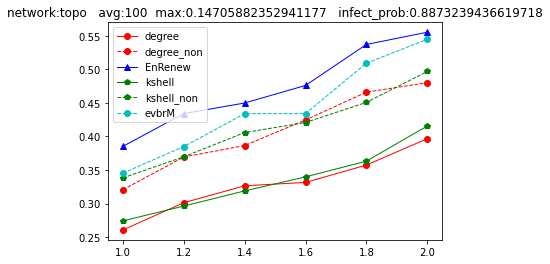

In [60]:
%matplotlib inline
plt.title('network:{}   avg:{}  max:{}   infect_prob:{}'.format(data_file, avg, max_, infect_prob))
plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_result, 'r-o', label='degree', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_non_result, 'r--o', label='degree_non', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_result, 'y-s', label='vote', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_non_result, 'y--s', label='vote_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, newmethod_result, 'b-^', label='EnRenew', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, kshell_result, 'g-p', label='kshell', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, kshell_non_result, 'g--p', label='kshell_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, evbrM_result, 'c--o', label='evbrM', linewidth=1.0, )
plt.legend()
plt.show()